In [1]:
# Download dataset
import os
import tarfile

dataset_tar = 'afad.tar.xz'
dataset_folder = 'AFAD-Full'

if dataset_folder not in os.listdir():
    !git clone https://github.com/John-niu-07/tarball.git
    !cat tarball/AFAD-Full.tar.xz* > {dataset_tar}
    !rm -rfv tarball
    !tar -xf {dataset_tar}
    !rm {dataset_tar}


In [2]:
# Dataset labelling
from tqdm import tqdm

filenames = []
ages = []

for age in tqdm(os.listdir(dataset_folder)):
    if (age == 'AFAD-Full.txt') or (age == 'README.md'):
        continue
    
    sub_folders = os.listdir(
        os.path.join(
            dataset_folder, age
        )
    )
    for sf in sub_folders:
        cur_folder = os.path.join(
            dataset_folder, age, sf
        )
        for file in os.listdir(cur_folder):
            filenames.append(
                os.path.join(
                    cur_folder, file
                )
            )
            ages.append(int(age))

print(filenames[:5], ages[:5])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.95it/s]

['AFAD-Full/64/111/856714-0.jpg', 'AFAD-Full/64/111/855820-0.jpg', 'AFAD-Full/64/111/857361-0.jpg', 'AFAD-Full/64/111/857255-0.jpg', 'AFAD-Full/64/111/856548-0.jpg'] [64, 64, 64, 64, 64]


In [3]:
# Create pandas dataframe
import pandas as pd

dataframe = pd.DataFrame(
    {
    'image_path': filenames,
    'age': ages
}
)
dataframe

,image_path,age
0,AFAD-Full/64/111/856714-0.jpg,64
1,AFAD-Full/64/111/855820-0.jpg,64
2,AFAD-Full/64/111/857361-0.jpg,64
3,AFAD-Full/64/111/857255-0.jpg,64
4,AFAD-Full/64/111/856548-0.jpg,64
...,...,...
165510,AFAD-Full/29/112/11946-0.jpg,29
165511,AFAD-Full/29/112/131797-1.jpg,29
165512,AFAD-Full/29/112/9525-0.jpg,29
165513,AFAD-Full/29/112/133678-0.jpg,29


In [4]:
# Create a label column

def convert_label(age):
    return 1 if int(age) >= 18 else 0

dataframe['label'] = dataframe['age'].apply(convert_label)
dataframe

,image_path,age,label
0,AFAD-Full/64/111/856714-0.jpg,64,1
1,AFAD-Full/64/111/855820-0.jpg,64,1
2,AFAD-Full/64/111/857361-0.jpg,64,1
3,AFAD-Full/64/111/857255-0.jpg,64,1
4,AFAD-Full/64/111/856548-0.jpg,64,1
...,...,...,...
165510,AFAD-Full/29/112/11946-0.jpg,29,1
165511,AFAD-Full/29/112/131797-1.jpg,29,1
165512,AFAD-Full/29/112/9525-0.jpg,29,1
165513,AFAD-Full/29/112/133678-0.jpg,29,1


label
1    159359
0      6156
Name: count, dtype: int64


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'label'}>]], dtype=object)

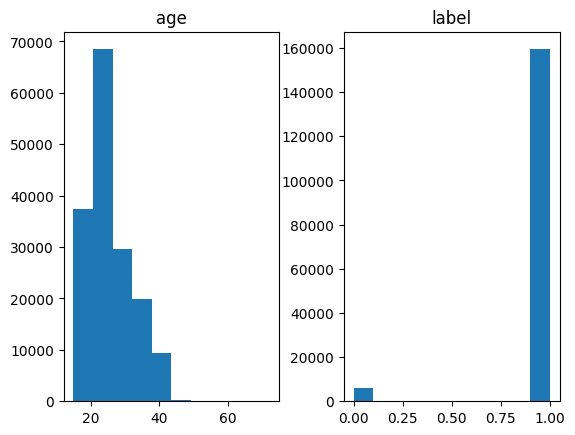

In [5]:
# Show label's histogram
print(dataframe['label'].value_counts())
dataframe.hist(grid=False)

label
0    6156
1    6156
Name: count, dtype: int64


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'label'}>]], dtype=object)

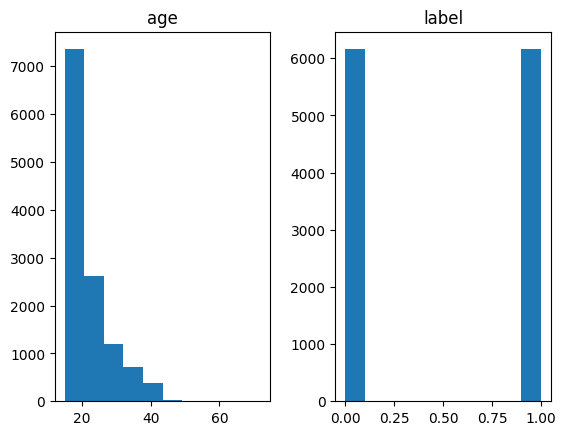

In [6]:
# Undersampling
total_per_label = dataframe['label'].value_counts().get(0)

undersampled_dataframe = dataframe.groupby('label').sample(n=total_per_label)

print(undersampled_dataframe['label'].value_counts())
undersampled_dataframe.hist(grid=False)

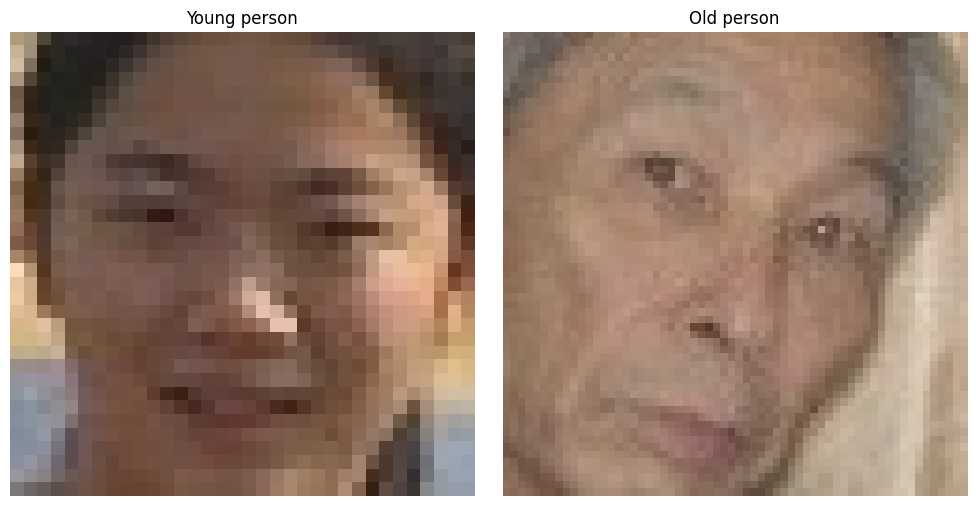

In [7]:
# Display sample image
import matplotlib.pyplot as plt
from PIL import Image

young_sample = undersampled_dataframe[undersampled_dataframe['age'] < 17].iloc[0]
old_sample = undersampled_dataframe[undersampled_dataframe['age'] > 50].iloc[0]

img_young = Image.open(young_sample.image_path)
img_old = Image.open(old_sample.image_path)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display first image
axes[0].imshow(img_young)
axes[0].axis("off")  # Hide axes
axes[0].set_title("Young person")

# Display second image
axes[1].imshow(img_old)
axes[1].axis("off")
axes[1].set_title("Old person")

# Adjust layout and show images
plt.tight_layout()
plt.show()

In [8]:
# remove 'age' column and reset index
undersampled_dataframe.drop(columns=['age'], inplace=True)
undersampled_dataframe.reset_index(drop=True, inplace=True)

In [9]:
# Create a PyTorch data loader
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Create a custom pytorch dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, image_size=224):
        """
        Args:
            dataframe (pd.DataFrame): Pandas DataFrame containing image paths and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transforms.Compose(
            [transforms.Resize((image_size, image_size)),
            transforms.ToTensor()]
        )  

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetch a sample (image and label) from the dataset."""
        img_name = self.dataframe.iloc[idx, 0]  # image path column
        label = self.dataframe.iloc[idx, 1]  # label column

        # Open the image
        image = Image.open(img_name).convert("RGB")  # Convert to RGB

        # Transform the image
        image = self.transform(image)

        return image, label


train_df, test_df = train_test_split(undersampled_dataframe, test_size=0.2)

train_dataset = ImageDataset(train_df)
test_dataset = ImageDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


KeyboardInterrupt



In [ ]:
# Check total training and testing dataset
print(f"Total samples for model training = {len(train_dataset)}")
print(f"Total samples for model evaluation = {len(test_dataset)}")

In [ ]:
# Define model and hyperparameters
import torch.nn as nn
from torchvision import models
import torch.optim as optim


class EfficientNetBinaryClassifier(nn.Module):
    def __init__(self):
        super(EfficientNetBinaryClassifier, self).__init__()
        self.model = models.efficientnet_v2_l(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)  # Change output to 1 neuron (binary classification)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = EfficientNetBinaryClassifier()


criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Model training loop
import torch

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
